# DATA PREPARATION

In [ ]:
import numpy as np
import pandas as pd
import pyhdb
from sqlalchemy import create_engine
from sqlalchemy.types import NVARCHAR
%matplotlib inline

In [116]:
chunksize = 100000
churn = pd.read_csv('data_20171001_20190930.csv', chunksize=100000, iterator=True)
data = pd.concat(churn, ignore_index=True)

In [45]:
data_head = data.head()
data_head['amount'] = data_head['amount'].map('${:,.2f}'.format)
data_head

,customer_id,date,quantity,amount
0,2100395099,20171026,17,$38.80
1,2100068562,20171012,36,$137.25
2,2100006589,20171009,22,$91.02
3,2100628482,20180102,8,$57.28
4,2100618183,20180111,12,$93.47


In [46]:
#Change the customer_id 
data_head = data_head.replace({'customer_id' : {2100395099: 1,2100068562:2,2100006589:3,2100628482:4, 2100618183:5}})
data_head

,customer_id,date,quantity,amount
0,1,20171026,17,$38.80
1,2,20171012,36,$137.25
2,3,20171009,22,$91.02
3,4,20180102,8,$57.28
4,5,20180111,12,$93.47


In [4]:
# Observing the dataset
data.describe()

,customer_id,date,quantity,amount
count,1.356140e+08,1.356140e+08,1.356140e+08,1.356140e+08
mean,2.100852e+09,2.018299e+07,1.377011e+01,6.362600e+01
std,5.723446e+05,6.472773e+03,1.515439e+01,7.349816e+01
min,2.100000e+09,2.017100e+07,1.000000e+00,1.000000e-02
25%,2.100369e+09,2.018033e+07,4.000000e+00,1.925000e+01
50%,2.100737e+09,2.018092e+07,9.000000e+00,3.924000e+01
75%,2.101371e+09,2.019032e+07,1.700000e+01,8.027000e+01
max,2.102082e+09,2.019093e+07,4.586000e+03,3.600000e+04


In [ ]:
data['date'] = pd.to_datetime(data.date, format="%Y%m%d")
from lifetimes.utils import summary_data_from_transaction_data
# lifetimes provides a transaction log -> rfm util function
training = summary_data_from_transaction_data(
     data,
    'customer_id',
    'date',
    monetary_value_col = 'amount',
    observation_period_end=pd.to_datetime('2018-09-30'),
    freq='D'
)
training.to_csv('training_day.csv')

In [1]:
data_20181001_20190930 = data[(data['date'] >=20181001) & (data['date'] <=20190930)]
data_20181001_20190930['date'] = pd.to_datetime(data_20181001_20190930.date, format="%Y%m%d")
from lifetimes.utils import summary_data_from_transaction_data
# lifetimes provides a transaction log -> rfm util function
test = summary_data_from_transaction_data(
     data_20181001_20190930,
    'customer_id',
    'date',
    monetary_value_col = 'amount',
    observation_period_end=pd.to_datetime('2019-09-30'),
    freq='D'
)
test.to_csv('test_day.csv')

NameError: name 'data' is not defined

In [3]:
# Reading the Training RFM(20171001~20180930) anad Test RFM(20181001~20190930)
training = pd.read_csv("training_day.csv",index_col='customer_id')
test = pd.read_csv("test_day.csv",index_col='customer_id')

C:\Python3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [20]:
# Chagne the column name and index
training_head = training.head()
training_head['monetary_value'] = training_head['monetary_value'].map('${:,.2f}'.format)
training_head.columns = ['Frequency: Numbers of repeated daily shopping','Recency: Days between First shopping date and last shopping date','T: Days between First shopping date and 20180930','Monetary_value: Average daily purchased spent']
training_head.rename(index={2100000000: 1,2100000001:2,2100000002:2,2100000003:3, 2100000004:4}, inplace= True)
training_head

,Frequency: Numbers of repeated daily shopping,Recency: Days between First shopping date and last shopping date,T: Days between First shopping date and 20180930,Monetary_value: Average daily purchased spent
customer_id,,,,
1,95.0,363.0,363.0,$95.27
2,96.0,358.0,362.0,$37.43
2,2.0,181.0,204.0,$13.79
3,140.0,361.0,362.0,$64.74
4,184.0,358.0,360.0,$20.97


In [5]:
training.head()

,frequency,recency,T,monetary_value
customer_id,,,,
2100000000,95.0,363.0,363.0,95.270421
2100000001,96.0,358.0,362.0,37.431458
2100000002,2.0,181.0,204.0,13.785000
2100000003,140.0,361.0,362.0,64.735357
2100000004,184.0,358.0,360.0,20.968859


# 1. Predicting the customer future transactions

### 1.1 Delete the outliers

Text(0.5,1,'Numbers of repeated daily shopping by NWNZ clubcard customers from 2017-10-01 to 2018-09-30')

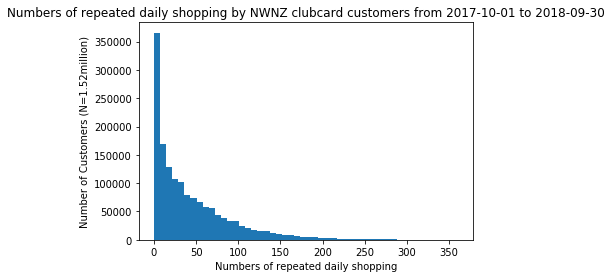

In [58]:
# Looking the rfm frequency distribution
%matplotlib inline
import matplotlib.pyplot as plt
training['frequency'].plot(kind='hist', bins=50)
plt.ylabel('Number of Customers (N=1.52million)')
plt.xlabel('Numbers of repeated daily shopping')
plt.title('Numbers of repeated daily shopping by NWNZ clubcard customers from 2017-10-01 to 2018-09-30')

Text(0.5,1,'Average daily purchased spent by NWNZ clubcard customers from 2017-10-01 to 2018-09-30')

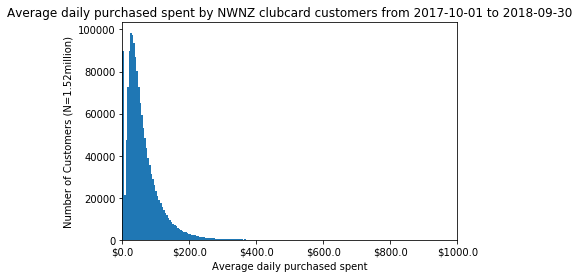

In [49]:
# Looking the rfm frequency distribution
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.xlim([0,1000])

ax = training['monetary_value'].plot(kind='hist', bins=1000)

formatter = ticker.FormatStrFormatter('$%0.1f') #declaring the formatter with the $ sign and y_values with 1 decimalplace
ax.xaxis.set_major_formatter(formatter)

plt.ylabel('Number of Customers (N=1.52million)')
plt.xlabel('Average daily purchased spent')
plt.title('Average daily purchased spent by NWNZ clubcard customers from 2017-10-01 to 2018-09-30')

Text(0.5,1,'Numbers of repeated daily shopping by NWNZ clubcard customers from 2017-10-01 to 2018-09-30')

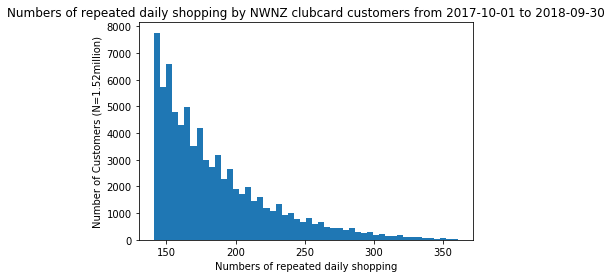

In [59]:
# Looking the frequency between 150 <
import matplotlib.pyplot as plt
training[(training['frequency'] >= 141) &(training['frequency'] <= 361)]['frequency'].plot(kind='hist', bins=50)
plt.ylabel('Number of Customers (N=1.52million)')
plt.xlabel('Numbers of repeated daily shopping')
plt.title('Numbers of repeated daily shopping by NWNZ clubcard customers from 2017-10-01 to 2018-09-30')

Text(0.5,1,'Average daily purchased spent by NWNZ clubcard customers from 2017-10-01 to 2018-09-30')

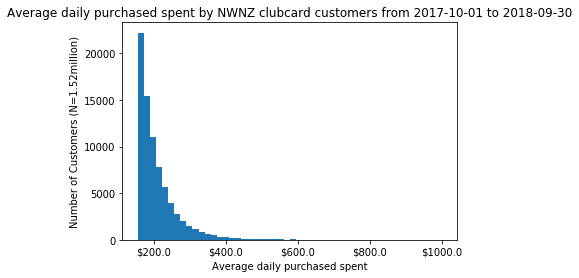

In [92]:
# Looking the monetary value $155<
import matplotlib.pyplot as plt
ax = training[(training['monetary_value'] >= 155) &(training['monetary_value'] <= 1000)]['monetary_value'].plot(kind='hist', bins=50)
formatter = ticker.FormatStrFormatter('$%0.1f') #declaring the formatter with the $ sign and y_values with 1 decimalplace
ax.xaxis.set_major_formatter(formatter)

plt.ylabel('Number of Customers (N=1.52million)')
plt.xlabel('Average daily purchased spent')
plt.title('Average daily purchased spent by NWNZ clubcard customers from 2017-10-01 to 2018-09-30')

In [55]:
training_describe = training.describe()[['frequency','monetary_value']]
training_describe.columns = ['Numbers of repeated daily shopping','Average daily purchased spent']
pd.options.display.float_format = '{:.5f}'.format
training_describe['Average daily purchased spent'] = training_describe['Average daily purchased spent'].map('${:,.2f}'.format)
training_describe

,Numbers of repeated daily shopping,Average daily purchased spent
count,1529966.00000,"$1,529,966.00"
mean,44.07936,$59.26
std,47.95064,$51.58
min,0.00000,$0.00
25%,8.00000,$26.30
50%,28.00000,$45.95
75%,64.00000,$78.02
max,361.00000,"$4,670.68"


In [60]:
# Delete the Outliers
training = training.loc[(training['frequency'] > 0) & (training['frequency'] <= 250)]

### 1.2 Model

In [61]:
# Using the BG/NBD model
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.05)
bgf.fit(training['frequency'], training['recency'], training['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.00384,0.00102,1.00184,1.00585
alpha,7.11020,0.00940,7.09178,7.12863
a,0.01795,0.00007,0.01782,0.01808
b,0.47081,0.00164,0.46760,0.47403


### 1.3 Customer Nuber of Repeated Daily Purchased prediction for next 1 year

In [62]:
#Predict for next 1 years = 365 days
training = training[training['frequency']>0]
t = 365
training['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, training['frequency'], training['recency'], training['T'])
training.head(5)

,frequency,recency,T,monetary_value,predicted_purchases
customer_id,,,,,
2100000000,95.00000,363.00000,363.00000,95.27042,94.00576
2100000001,96.00000,358.00000,362.00000,37.43146,95.20753
2100000002,2.00000,181.00000,204.00000,13.78500,5.02994
2100000003,140.00000,361.00000,362.00000,64.73536,138.44522
2100000004,184.00000,358.00000,360.00000,20.96886,182.61888


### 1.4 Calibration dataset VS holdout dataset

In [76]:
# Reading the Training RFM(20171001~20180930) anad Test RFM(20181001~20190930)
training = pd.read_csv("training_day.csv",index_col='customer_id')
test = pd.read_csv("test_day.csv",index_col='customer_id')

# Creating the Calibration_Holdout dataset
training.columns = ['frequency_cal','recency_cal','T_cal','monetary_value_cal']
test.columns = ['Actual Repeated Daily Purchases','recency_holdout','duration_holdout','monetary_value_holdout']
summary_cal_holdout = pd.concat([training[['frequency_cal','recency_cal','T_cal']],test[['Actual Repeated Daily Purchases','duration_holdout']]], axis =1).dropna()

In [77]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,Actual Repeated Daily Purchases,duration_holdout
customer_id,,,,,
2100000000,95.00000,363.00000,363.00000,37.00000,362.00000
2100000001,96.00000,358.00000,362.00000,77.00000,353.00000
2100000002,2.00000,181.00000,204.00000,4.00000,335.00000
2100000003,140.00000,361.00000,362.00000,143.00000,364.00000
2100000004,184.00000,358.00000,360.00000,199.00000,364.00000


In [78]:
summary_cal_holdout.describe()

,frequency_cal,recency_cal,T_cal,Actual Repeated Daily Purchases,duration_holdout
count,1372914.00000,1372914.00000,1372914.00000,1372914.00000,1372914.00000
mean,47.98478,293.60779,324.94564,46.10974,334.38592
std,48.69010,100.00310,72.20270,48.57796,57.36147
min,0.00000,0.00000,0.00000,0.00000,0.00000
25%,11.00000,274.00000,329.00000,9.00000,338.00000
50%,33.00000,343.00000,357.00000,31.00000,358.00000
75%,69.00000,358.00000,362.00000,67.00000,362.00000
max,361.00000,364.00000,364.00000,362.00000,364.00000


In [79]:
#Delete the outliers
summary_cal_holdout = summary_cal_holdout.query('frequency_cal <= 250')

C:\Python3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


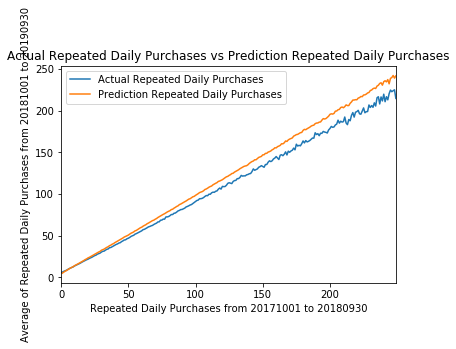

In [80]:
# Draw the calibration_purchases_vs_holdout_purchases Graph
def plot_calibration_purchases_vs_holdout_purchases(
    model, calibration_holdout_matrix, kind="frequency_cal", n=7, **kwargs
):
    """
    Plot calibration purchases vs holdout.
    This currently relies too much on the lifetimes.util calibration_and_holdout_data function.
    Parameters
    ----------
    model: lifetimes model
        A fitted lifetimes model.
    calibration_holdout_matrix: pandas DataFrame
        DataFrame from calibration_and_holdout_data function.
    kind: str, optional
        x-axis :"frequency_cal". Purchases in calibration period,
                 "recency_cal". Age of customer at last purchase,
                 "T_cal". Age of customer at the end of calibration period,
                 "time_since_last_purchase". Time since user made last purchase
    n: int, optional
        Number of ticks on the x axis
    Returns
    -------
    axes: matplotlib.AxesSubplot
    """
    from matplotlib import pyplot as plt

    x_labels = {
        "frequency_cal": "Repeated Daily Purchases from 20171001 to 20180930",
        "recency_cal": "Age of customer at last purchase",
        "T_cal": "Age of customer at the end of calibration period",
        "time_since_last_purchase": "Time since user made last purchase",
    }
    summary = calibration_holdout_matrix.copy()
    duration_holdout = summary.iloc[0]["duration_holdout"]

    summary["Prediction Repeated Daily Purchases"] = model.conditional_expected_number_of_purchases_up_to_time(
            duration_holdout, summary["frequency_cal"], summary["recency_cal"], summary["T_cal"])

    if kind == "time_since_last_purchase":
        summary["time_since_last_purchase"] = summary["T_cal"] - summary["recency_cal"]
        ax = (
            summary.groupby(["time_since_last_purchase"])[["Actual Repeated Daily Purchases", "Prediction Repeated Daily Purchases"]]
            .mean()
            .iloc[:n]
            .plot(**kwargs)
        )
    else:
        ax = summary.groupby(kind)[["Actual Repeated Daily Purchases", "Prediction Repeated Daily Purchases"]].mean().iloc[:n].plot(**kwargs)

    plt.title("Actual Repeated Daily Purchases vs Prediction Repeated Daily Purchases")
    plt.xlabel(x_labels[kind])
    plt.ylabel("Average of Repeated Daily Purchases from 20181001 to 20190930")
    plt.legend()

    return ax

import matplotlib.pyplot as plt
bgf = BetaGeoFitter(penalizer_coef=0.05)
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
fig = plt.figure(figsize=(16,12))
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, n=250)

### 1.5 Prediction Error

In [82]:
summary_cal_holdout = summary_cal_holdout[summary_cal_holdout['frequency_cal']>0]
t = 365
summary_cal_holdout['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
holdout = summary_cal_holdout['Actual Repeated Daily Purchases'].sum(axis = 0)
prediction = summary_cal_holdout['predicted_purchases'].sum(axis = 0)
(prediction-holdout)/holdout

0.08460151246276497

8.4% Prediction error

# 2. Predicting the customer probability of Churn

### 2.1 Calculating the probability of Churn at the 20190930

In [34]:
# Import the Training and test dataset
training = pd.read_csv("training_day.csv",index_col='customer_id')
test = pd.read_csv("test_day.csv",index_col='customer_id')

#Delete outliers
training = training.loc[(training['frequency'] > 0) & (training['frequency'] <= 250)]

# Using the BG/NBD model
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.05)
bgf.fit(training['frequency'], training['recency'], training['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.003844,0.001022,1.001841,1.005846
alpha,7.110203,0.009399,7.091781,7.128626
a,0.017952,0.000065,0.017824,0.018079
b,0.470814,0.001640,0.467599,0.474029


In [35]:
#Predict that customers still alive on the date of 2019-09-30
test_probability_alive = test[test['frequency']>0]
test_probability_alive['Churn'] = 1 - bgf.conditional_probability_alive(test_probability_alive['frequency'], test_probability_alive['recency'], test_probability_alive['T'])
test_probability_alive.head(5)

,frequency,recency,T,monetary_value,Churn
customer_id,,,,,
2100000000,37.0,311.0,362.0,134.787838,0.122873
2100000001,77.0,347.0,353.0,31.061558,0.000870
2100000002,4.0,309.0,335.0,29.300000,0.007623
2100000003,143.0,357.0,364.0,59.866783,0.001952
2100000004,199.0,364.0,364.0,19.970553,0.000090


Text(0.5,1,'Customer Probability of Churn Distributaion')

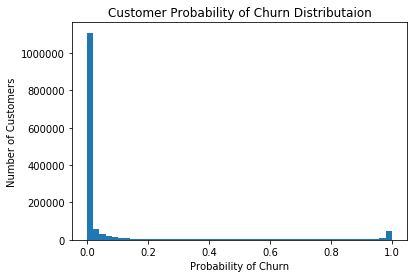

In [51]:
# Distribution for the pobability of alive 
%matplotlib inline
import matplotlib.pyplot as plt
test_probability_alive['Churn'].plot(kind='hist', bins=50)
plt.ylabel('Number of Customers')
plt.xlabel('Probability of Churn')
plt.title('Customer Probability of Churn Distributaion')

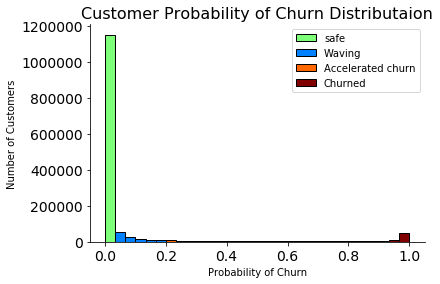

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

data = test_probability_alive['Churn']

N, bins, patches = plt.hist(data, 30, ec="k")

cmap = plt.get_cmap('jet')
low = cmap(0.5)
medium =cmap(0.25)
high = cmap(0.8)
very_high = cmap(1.0)

for i in range(0,1):
    patches[i].set_facecolor(low)
for i in range(1,6):
    patches[i].set_facecolor(medium)
for i in range(6,15):
    patches[i].set_facecolor(high)
for i in range(15,30):
    patches[i].set_facecolor(very_high)

#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [low,medium, high,very_high]]
labels= ["safe","Waving", "Accelerated churn", "Churned"]
plt.legend(handles, labels)

plt.xlabel("Probability of Churn", fontsize=10)  
plt.ylabel("Number of Customers", fontsize=10)
plt.title('Customer Probability of Churn Distributaion', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

plt.show()

In [80]:
# Portion of waving customers
test_probability_alive[(test_probability_alive['Churn'] > 0.05) & ((test_probability_alive['Churn'] <=0.2))].shape[0]/test_probability_alive.shape[0]

0.057298073850347984

### 2.2 Probability of Churned by Loyalty Group

In [91]:
RFM_Customer = pd.read_csv('CHURN_RFM_CUSTOMER.csv')
bb = test_probability_alive.reset_index('customer_id')[['customer_id','Churn']]
RFM_Customer_Alive = pd.merge(bb, RFM_Customer, how='inner', left_on = 'customer_id', right_on = 'BUSINESS_PARTNER_ID')
RFM_Customer_Alive.head()

,customer_id,Churn,BUSINESS_PARTNER_ID,LOYALTY_GROUP_MD
0,2100000000,0.12287,2100000000,Unassigned
1,2100000001,0.00087,2100000001,Habitual
2,2100000002,0.00762,2100000002,Irregular
3,2100000003,0.00195,2100000003,VIP
4,2100000004,0.00009,2100000004,Habitual


#### VIP

In [92]:
RFM_Customer_Alive_VIP = RFM_Customer_Alive[RFM_Customer_Alive['LOYALTY_GROUP_MD'] == 'VIP']
safe = RFM_Customer_Alive_VIP[(RFM_Customer_Alive_VIP['Churn'] >=0) & (RFM_Customer_Alive_VIP['Churn'] <= 0.05)].count()/RFM_Customer_Alive_VIP.count()
Waving = RFM_Customer_Alive_VIP[(RFM_Customer_Alive_VIP['Churn'] >0.05) & (RFM_Customer_Alive_VIP['Churn'] <= 0.2)].count()/RFM_Customer_Alive_VIP.count()
Accelerated_Churn = RFM_Customer_Alive_VIP[(RFM_Customer_Alive_VIP['Churn'] >0.2) & (RFM_Customer_Alive_VIP['Churn'] <= 0.5)].count()/RFM_Customer_Alive_VIP.count()
Churned = RFM_Customer_Alive_VIP[(RFM_Customer_Alive_VIP['Churn'] >0.5) & (RFM_Customer_Alive_VIP['Churn'] <= 1)].count()/RFM_Customer_Alive_VIP.count()
dataframe = {'Safe':[safe.customer_id],'Waving':[Waving.customer_id], 'Accelerated_Churn': [Accelerated_Churn.customer_id], 'Churned':[Churned.customer_id]}

vip_dataframe = pd.DataFrame(dataframe)
vip_dataframe.rename(index={0: 'VIP'}, inplace= True)
vip_dataframe

,Safe,Waving,Accelerated_Churn,Churned
VIP,0.99654,0.00166,0.00075,0.00105


#### Loyal

In [93]:
RFM_Customer_Alive_loyal = RFM_Customer_Alive[RFM_Customer_Alive['LOYALTY_GROUP_MD'] == 'Loyal']
safe = RFM_Customer_Alive_loyal[(RFM_Customer_Alive_loyal['Churn'] >=0) & (RFM_Customer_Alive_loyal['Churn'] <= 0.05)].count()/RFM_Customer_Alive_loyal.count()
Waving = RFM_Customer_Alive_loyal[(RFM_Customer_Alive_loyal['Churn'] >0.05) & (RFM_Customer_Alive_loyal['Churn'] <= 0.2)].count()/RFM_Customer_Alive_loyal.count()
Accelerated_Churn = RFM_Customer_Alive_loyal[(RFM_Customer_Alive_loyal['Churn'] >0.2) & (RFM_Customer_Alive_loyal['Churn'] <= 0.5)].count()/RFM_Customer_Alive_loyal.count()
Churned = RFM_Customer_Alive_loyal[(RFM_Customer_Alive_loyal['Churn'] >0.5) & (RFM_Customer_Alive_loyal['Churn'] <= 1)].count()/RFM_Customer_Alive_loyal.count()
dataframe = {'Safe':[safe.customer_id],'Waving':[Waving.customer_id], 'Accelerated_Churn': [Accelerated_Churn.customer_id], 'Churned':[Churned.customer_id]}

loyal_dataframe = pd.DataFrame(dataframe)
loyal_dataframe.rename(index={0: 'LOYAL'}, inplace= True)
loyal_dataframe

,Safe,Waving,Accelerated_Churn,Churned
LOYAL,0.99645,0.00192,0.00072,0.00090


#### Habitual

In [94]:
RFM_Customer_Alive_Habitual = RFM_Customer_Alive[RFM_Customer_Alive['LOYALTY_GROUP_MD'] == 'Habitual']
safe = RFM_Customer_Alive_Habitual[(RFM_Customer_Alive_Habitual['Churn'] >=0) & (RFM_Customer_Alive_Habitual['Churn'] <= 0.05)].count()/RFM_Customer_Alive_Habitual.count()
Waving = RFM_Customer_Alive_Habitual[(RFM_Customer_Alive_Habitual['Churn'] >0.05) & (RFM_Customer_Alive_Habitual['Churn'] <= 0.2)].count()/RFM_Customer_Alive_Habitual.count()
Accelerated_Churn = RFM_Customer_Alive_Habitual[(RFM_Customer_Alive_Habitual['Churn'] >0.2) & (RFM_Customer_Alive_Habitual['Churn'] <= 0.5)].count()/RFM_Customer_Alive_Habitual.count()
Churned = RFM_Customer_Alive_Habitual[(RFM_Customer_Alive_Habitual['Churn'] >0.5) & (RFM_Customer_Alive_Habitual['Churn'] <= 1)].count()/RFM_Customer_Alive_Habitual.count()
dataframe = {'Safe':[safe.customer_id],'Waving':[Waving.customer_id], 'Accelerated_Churn': [Accelerated_Churn.customer_id], 'Churned':[Churned.customer_id]}

Habitual_dataframe = pd.DataFrame(dataframe)
Habitual_dataframe.rename(index={0: 'HABITUAL'}, inplace= True)
Habitual_dataframe

,Safe,Waving,Accelerated_Churn,Churned
HABITUAL,0.99718,0.00192,0.00052,0.00038


#### Desirables

In [95]:
RFM_Customer_Alive_Desirables = RFM_Customer_Alive[RFM_Customer_Alive['LOYALTY_GROUP_MD'] == 'Desirables']
safe = RFM_Customer_Alive_Desirables[(RFM_Customer_Alive_Desirables['Churn'] >=0) & (RFM_Customer_Alive_Desirables['Churn'] <= 0.05)].count()/RFM_Customer_Alive_Desirables.count()
Waving = RFM_Customer_Alive_Desirables[(RFM_Customer_Alive_Desirables['Churn'] >0.05) & (RFM_Customer_Alive_Desirables['Churn'] <= 0.2)].count()/RFM_Customer_Alive_Desirables.count()
Accelerated_Churn = RFM_Customer_Alive_Desirables[(RFM_Customer_Alive_Desirables['Churn'] >0.2) & (RFM_Customer_Alive_Desirables['Churn'] <= 0.5)].count()/RFM_Customer_Alive_Desirables.count()
Churned = RFM_Customer_Alive_Desirables[(RFM_Customer_Alive_Desirables['Churn'] >0.5) & (RFM_Customer_Alive_Desirables['Churn'] <= 1)].count()/RFM_Customer_Alive_Desirables.count()
dataframe = {'Safe':[safe.customer_id],'Waving':[Waving.customer_id], 'Accelerated_Churn': [Accelerated_Churn.customer_id], 'Churned':[Churned.customer_id]}

Desirables_dataframe = pd.DataFrame(dataframe)
Desirables_dataframe.rename(index={0: 'DESIRABLES'}, inplace= True)
Desirables_dataframe

,Safe,Waving,Accelerated_Churn,Churned
DESIRABLES,0.93149,0.02665,0.01156,0.03029


#### Others

In [96]:
RFM_Customer_Alive_Others = RFM_Customer_Alive[RFM_Customer_Alive['LOYALTY_GROUP_MD'].isin(['Irregular','Switchers','Casual / Top-Ups','Unassigned	'])]
safe = RFM_Customer_Alive_Others[(RFM_Customer_Alive_Others['Churn'] >=0) & (RFM_Customer_Alive_Others['Churn'] <= 0.05)].count()/RFM_Customer_Alive_Others.count()
Waving = RFM_Customer_Alive_Others[(RFM_Customer_Alive_Others['Churn'] >0.05) & (RFM_Customer_Alive_Others['Churn'] <= 0.2)].count()/RFM_Customer_Alive_Others.count()
Accelerated_Churn = RFM_Customer_Alive_Others[(RFM_Customer_Alive_Others['Churn'] >0.2) & (RFM_Customer_Alive_Others['Churn'] <= 0.5)].count()/RFM_Customer_Alive_Others.count()
Churned = RFM_Customer_Alive_Others[(RFM_Customer_Alive_Others['Churn'] >0.5) & (RFM_Customer_Alive_Others['Churn'] <= 1)].count()/RFM_Customer_Alive_Others.count()
dataframe = {'Safe':[safe.customer_id],'Waving':[Waving.customer_id], 'Accelerated_Churn': [Accelerated_Churn.customer_id], 'Churned':[Churned.customer_id]}

Others_dataframe = pd.DataFrame(dataframe)
Others_dataframe.rename(index={0: 'OTHERS'}, inplace= True)
Others_dataframe

,Safe,Waving,Accelerated_Churn,Churned
OTHERS,0.87365,0.06110,0.02539,0.03986


In [97]:
frames = [vip_dataframe, loyal_dataframe, Habitual_dataframe,Desirables_dataframe,Others_dataframe]
result = pd.concat(frames)
result

,Safe,Waving,Accelerated_Churn,Churned
VIP,0.99654,0.00166,0.00075,0.00105
LOYAL,0.99645,0.00192,0.00072,0.00090
HABITUAL,0.99718,0.00192,0.00052,0.00038
DESIRABLES,0.93149,0.02665,0.01156,0.03029
OTHERS,0.87365,0.06110,0.02539,0.03986


Populating the interactive namespace from numpy and matplotlib


C:\Python3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5,1,'Probability of Churned by Loyalty Group')

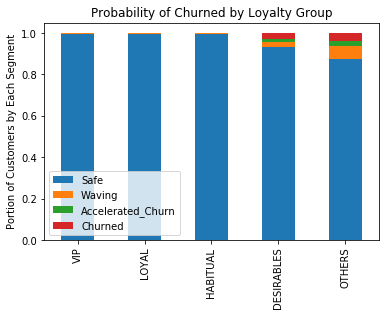

In [98]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt

ax = result.plot(kind='bar', stacked=True)
plt.ylabel('Portion of Customers by Each Segment')
plt.title('Probability of Churned by Loyalty Group')


### 2.3 Plotting the probability of churn graphs

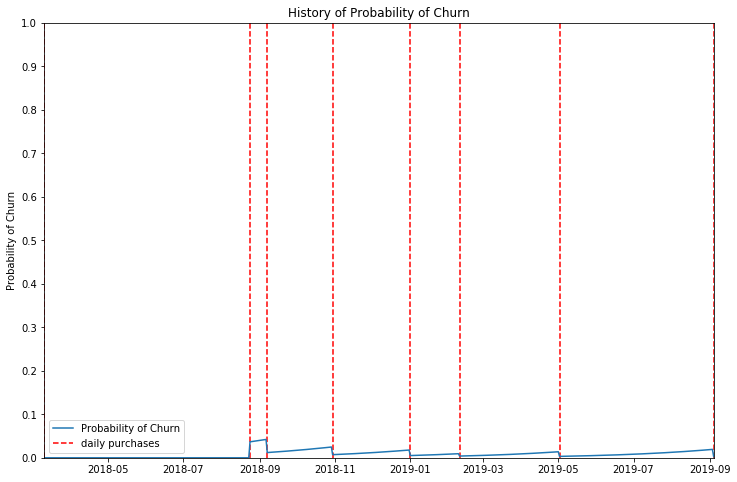

In [13]:
from lifetimes.utils import calculate_alive_path
def plot_history_alive(model, t, transactions, datetime_col, freq="D", start_date=None, ax=None, **kwargs):
    """
    Draw a graph showing the probability of being alive for a customer in time.
    Parameters
    ----------
    model: lifetimes model
        A fitted lifetimes model.
    t: int
        the number of time units since the birth we want to draw the p_alive
    transactions: pandas DataFrame
        DataFrame containing the transactions history of the customer_id
    datetime_col: str
        The column in the transactions that denotes the datetime the purchase was made
    freq: str, optional
        Default 'D' for days. Other examples= 'W' for weekly
    start_date: datetime, optional
        Limit xaxis to start date
    ax: matplotlib.AxesSubplot, optional
        Using user axes
    kwargs
        Passed into the matplotlib.pyplot.plot command.
    Returns
    -------
    axes: matplotlib.AxesSubplot
    """
    from matplotlib import pyplot as plt

    if start_date is None:
        start_date = min(transactions[datetime_col])

    if ax is None:
        ax = plt.subplot(111)

    # Get purchasing history of user
    customer_history = transactions[[datetime_col]].copy()
    customer_history.index = pd.DatetimeIndex(customer_history[datetime_col])

    # Add transactions column
    customer_history["transactions"] = 1
    customer_history = customer_history.resample(freq).sum()

    # plot alive_path
    path = calculate_alive_path(model, transactions, datetime_col, t, freq)
    path = 1 - path
    path_dates = pd.date_range(start=min(transactions[datetime_col]), periods=len(path), freq=freq)
    plt.plot(path_dates, path, "-", label="Probability of Churn")

    # plot buying dates
    payment_dates = customer_history[customer_history["transactions"] >= 1].index
    plt.vlines(payment_dates.values, ymin=0, ymax=1, colors="r", linestyles="dashed", label="daily purchases")

    plt.ylim(0, 1.0)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlim(start_date, path_dates[-1])
    plt.legend(loc=3)
    plt.ylabel("Probability of Churn")
    plt.title("History of Probability of Churn")

    return ax

import matplotlib.pyplot as plt
data['date'] = pd.to_datetime(data.date, format="%Y%m%d")
data_test = data[data['date'] >= '2018-03-01']
fig = plt.figure(figsize=(12,8))
id = 2100000002
days_since_birth = 300
sp_trans = data_test.loc[data_test['customer_id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

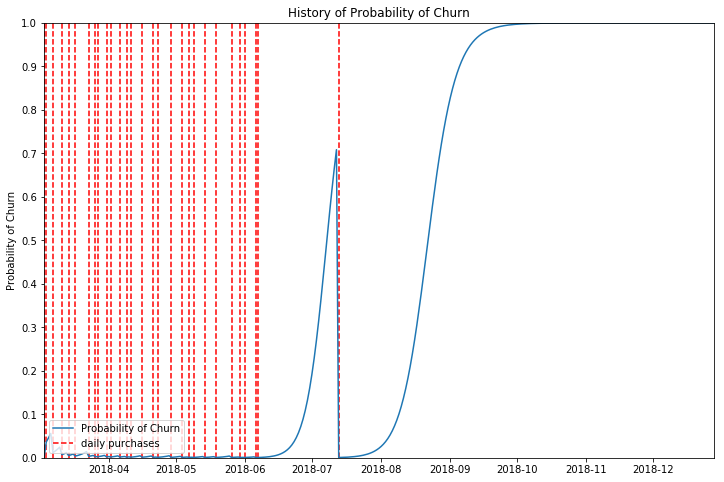

In [15]:
from lifetimes.utils import calculate_alive_path
def plot_history_alive(model, t, transactions, datetime_col, freq="D", start_date=None, ax=None, **kwargs):
    """
    Draw a graph showing the probability of being alive for a customer in time.
    Parameters
    ----------
    model: lifetimes model
        A fitted lifetimes model.
    t: int
        the number of time units since the birth we want to draw the p_alive
    transactions: pandas DataFrame
        DataFrame containing the transactions history of the customer_id
    datetime_col: str
        The column in the transactions that denotes the datetime the purchase was made
    freq: str, optional
        Default 'D' for days. Other examples= 'W' for weekly
    start_date: datetime, optional
        Limit xaxis to start date
    ax: matplotlib.AxesSubplot, optional
        Using user axes
    kwargs
        Passed into the matplotlib.pyplot.plot command.
    Returns
    -------
    axes: matplotlib.AxesSubplot
    """
    from matplotlib import pyplot as plt

    if start_date is None:
        start_date = min(transactions[datetime_col])

    if ax is None:
        ax = plt.subplot(111)

    # Get purchasing history of user
    customer_history = transactions[[datetime_col]].copy()
    customer_history.index = pd.DatetimeIndex(customer_history[datetime_col])

    # Add transactions column
    customer_history["transactions"] = 1
    customer_history = customer_history.resample(freq).sum()

    # plot alive_path
    path = calculate_alive_path(model, transactions, datetime_col, t, freq)
    path = 1 - path
    path_dates = pd.date_range(start=min(transactions[datetime_col]), periods=len(path), freq=freq)
    plt.plot(path_dates, path, "-", label="Probability of Churn")

    # plot buying dates
    payment_dates = customer_history[customer_history["transactions"] >= 1].index
    plt.vlines(payment_dates.values, ymin=0, ymax=1, colors="r", linestyles="dashed", label="daily purchases")

    plt.ylim(0, 1.0)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlim(start_date, path_dates[-1])
    plt.legend(loc=3)
    plt.ylabel("Probability of Churn")
    plt.title("History of Probability of Churn")

    return ax


import matplotlib.pyplot as plt
data['date'] = pd.to_datetime(data.date, format="%Y%m%d")
data_test = data[data['date'] >= '2018-03-01']
fig = plt.figure(figsize=(12,8))
id = 2100002272
days_since_birth = 300
sp_trans = data_test.loc[data_test['customer_id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

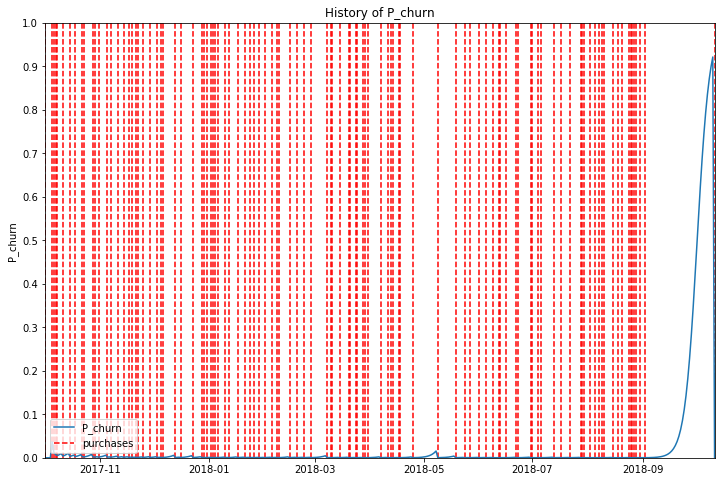

In [16]:
from lifetimes.utils import calculate_alive_path
def plot_history_alive(model, t, transactions, datetime_col, freq="D", start_date=None, ax=None, **kwargs):
    """
    Draw a graph showing the probability of being alive for a customer in time.
    Parameters
    ----------
    model: lifetimes model
        A fitted lifetimes model.
    t: int
        the number of time units since the birth we want to draw the p_alive
    transactions: pandas DataFrame
        DataFrame containing the transactions history of the customer_id
    datetime_col: str
        The column in the transactions that denotes the datetime the purchase was made
    freq: str, optional
        Default 'D' for days. Other examples= 'W' for weekly
    start_date: datetime, optional
        Limit xaxis to start date
    ax: matplotlib.AxesSubplot, optional
        Using user axes
    kwargs
        Passed into the matplotlib.pyplot.plot command.
    Returns
    -------
    axes: matplotlib.AxesSubplot
    """
    from matplotlib import pyplot as plt

    if start_date is None:
        start_date = min(transactions[datetime_col])

    if ax is None:
        ax = plt.subplot(111)

    # Get purchasing history of user
    customer_history = transactions[[datetime_col]].copy()
    customer_history.index = pd.DatetimeIndex(customer_history[datetime_col])

    # Add transactions column
    customer_history["transactions"] = 1
    customer_history = customer_history.resample(freq).sum()

    # plot alive_path
    path = calculate_alive_path(model, transactions, datetime_col, t, freq)
    path = 1 - path
    path_dates = pd.date_range(start=min(transactions[datetime_col]), periods=len(path), freq=freq)
    plt.plot(path_dates, path, "-", label="P_churn")

    # plot buying dates
    payment_dates = customer_history[customer_history["transactions"] >= 1].index
    plt.vlines(payment_dates.values, ymin=0, ymax=1, colors="r", linestyles="dashed", label="purchases")

    plt.ylim(0, 1.0)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlim(start_date, path_dates[-1])
    plt.legend(loc=3)
    plt.ylabel("P_churn")
    plt.title("History of P_churn")

    return ax



import matplotlib.pyplot as plt
data['date'] = pd.to_datetime(data.date, format="%Y%m%d")
data_test = data[(data['date'] >= '2017-10-01') &(data['date'] <= '2018-10-11')]
fig = plt.figure(figsize=(12,8))
id = 2101275685
days_since_birth = 300
sp_trans = data_test.loc[data_test['customer_id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

### 2.4 Customer Probability of Churn Path

In [20]:
# calculate_alive_path function can calculate the probability of churn for every shopping day for one customer
# For example the customer 2101823123, the above graph also shows this custoemr probability of churn changing
from lifetimes.utils import calculate_alive_path

data['date'] = pd.to_datetime(data.date, format="%Y%m%d")
data_test = data[data['date'] >= '2017-10-01']
id = 2101275685
days_since_birth = 300
sp_trans = data_test.loc[data_test['customer_id'] == id]
alive_path = pd.DataFrame(1-calculate_alive_path(bgf, sp_trans, 'date', days_since_birth, freq='D'))
alive_path.columns = ['Churn']
alive_path.head(10)

,Churn
0,[0.0]
1,[0.0]
2,[0.0]
3,[0.0]
4,[0.03672895043030333]
5,[0.012058212994218498]
6,[0.0072131556809612585]
7,[0.0051456177401969505]
8,[0.007233104958928149]
9,[0.009940297894374006]


### 2.4 Prediction Date Range

In [22]:
# Importing the data
chunksize = 100000
churn = pd.read_csv('data_20171001_20190930.csv', chunksize=100000, iterator=True)
data = pd.concat(churn, ignore_index=True)

# Manipulate the day range
date_range = data[(data['date'] >= 20181001) &(data['date'] <= 20190930)]
date_range['date'] = pd.to_datetime(date_range.date, format="%Y%m%d")

min=pd.DataFrame(date_range.groupby('customer_id')['date'].min())
max=pd.DataFrame(date_range.groupby('customer_id')['date'].max())
min_max = pd.concat([min,max], axis=1)
min_max['Date_Range'] = min_max.iloc[:,1] - min_max.iloc[:,0]

min_max.columns = ['min_date','max_date','date_range']
min_max['date_range'] = min_max['date_range'].dt.days
min_max.head()

,min_date,max_date,date_range
customer_id,,,
2100000000,2018-10-03,2019-08-10,311
2100000001,2018-10-12,2019-09-24,347
2100000002,2018-10-30,2019-09-04,309
2100000003,2018-10-01,2019-09-23,357
2100000004,2018-10-01,2019-09-30,364


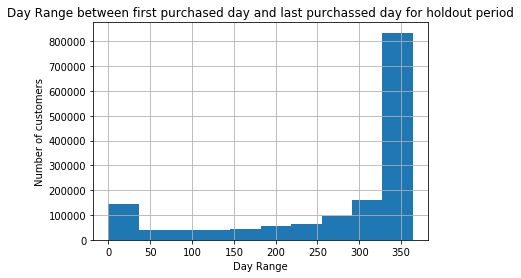

In [23]:
import matplotlib.pyplot as plt
ax = min_max['date_range'].hist()
plt.ylabel('Number of customers')
plt.xlabel('Day Range')
plt.title('Day Range between first purchased day and last purchassed day for holdout period')
#ax.legend().set_visible(False)
plt.show()

# 3. Predicting the customer average daily spend

### 3.1 Delte Outliers for Training Dataset

In [27]:
# Importing data
# Import the Training and test dataset
training = pd.read_csv("training_day.csv",index_col='customer_id')
test = pd.read_csv("test_day.csv",index_col='customer_id')

#Delete the outlier
lower_bound = 0.1
upper_bound = 0.95
training.frequency.quantile([lower_bound,upper_bound])

0.10      2.0
0.95    141.0
Name: frequency, dtype: float64

Text(0.5,1,'Customer Frequency Distribution')

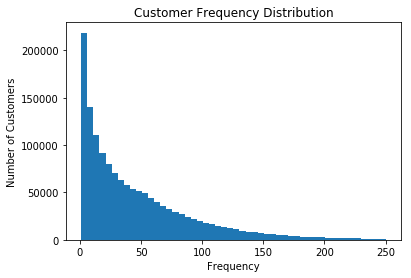

In [26]:
# Looking the rfm frequency distribution
%matplotlib inline
import matplotlib.pyplot as plt
training['frequency'].plot(kind='hist', bins=50)
plt.ylabel('Number of Customers')
plt.xlabel('Frequency')
plt.title('Customer Frequency Distribution')

Text(0.5,1,'Customer Monetary value Distribution')

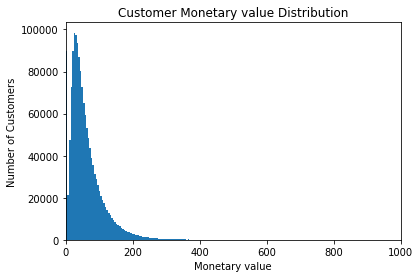

In [29]:
# Looking the rfm frequency distribution
import matplotlib.pyplot as plt
plt.xlim([0,1000])
training['monetary_value'].plot(kind='hist', bins=1000)
plt.ylabel('Number of Customers')
plt.xlabel('Monetary value')
plt.title('Customer Monetary value Distribution')

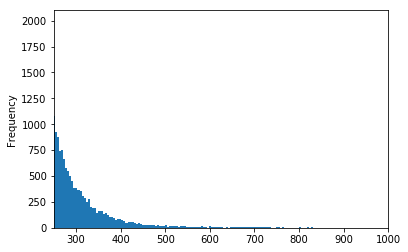

In [30]:
# Looking more detail about the monetary value
import matplotlib.pyplot as plt
plt.xlim([250,1000])
plt.ylim([0,2100])
training['monetary_value'].plot(kind='hist', bins=1000)

In [31]:
# delete the outlier
training = training.loc[(training['frequency'] > 0) & (training['frequency'] < 250)& (training['monetary_value'] <= 400)]

In [32]:
training[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.014694
monetary_value,0.014694,1.000000


In [31]:
corr = {'Repeated Daily Purchase':[1.000000,0.014694], 'Average Daily Spend': [1.000000,0.014694]}
corr = pd.DataFrame(corr)
corr.rename(index = {0:'Repeated Daily Purchase',1:'Average Daily Spend'})

,Repeated Daily Purchase,Average Daily Spend
Repeated Daily Purchase,1.000000,1.000000
Average Daily Spend,0.014694,0.014694


### 3.2 Building Model

In [33]:
# refit the BG model to the summary_with_money_value dataset
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.08)
bgf.fit(training['frequency'], training['recency'], training['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.927490,0.000908,0.925710,0.929271
alpha,6.571873,0.008645,6.554929,6.588817
a,0.016058,0.000059,0.015942,0.016174
b,0.392133,0.001309,0.389567,0.394699


In [35]:
# Build the model
training = training[training['frequency']>0]
training = training[training['monetary_value']>0]

from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(training['frequency'],
        training['monetary_value'])
print(ggf.summary)

       coef  se(coef)  lower 95% bound  upper 95% bound
p  3.906088  0.004008         3.898232         3.913945
q  0.714975  0.000718         0.713568         0.716382
v  3.873013  0.004034         3.865106         3.880919


In [36]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        training['frequency'],
        training['monetary_value']
    ).mean(),
    training[training['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 63.31318311836954, Average profit: 62.382159180408294


In [37]:
training_predict = ggf.conditional_expected_average_profit(
        training['frequency'],
        training['monetary_value'])

training_actual = training['monetary_value']
training_predict_actual = pd.concat([training_actual,training_predict],axis =1)
# Rename the column name
training_predict_actual.columns = ['Actual', 'Predict']
training_predict_actual['difference'] = (training_predict_actual['Predict']-training_predict_actual['Actual'])/training_predict_actual['Actual']*100
training_predict_actual.head()

,Actual,Predict,difference
customer_id,,,
2100000000,95.270421,95.384454,0.119694
2100000001,37.431458,37.500306,0.183930
2100000002,13.785000,16.316822,18.366496
2100000003,64.735357,64.796794,0.094905
2100000004,20.968859,20.998235,0.140095


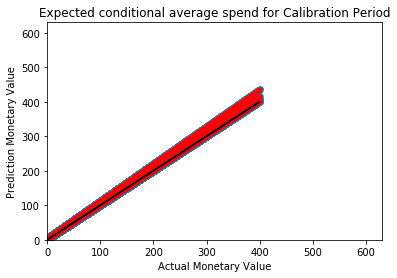

In [38]:
#All cusotmer 
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlim([0,630])
plt.ylim([0,630])
x = training_predict_actual['Actual'] 
y = training_predict_actual['Predict']

plt.plot(x,y,'r.') # x vs y
plt.plot(x,x,'k-') # identity line

plt.ylabel('Prediction Monetary Value')
plt.xlabel('Actual Monetary Value')
plt.title('Expected conditional average spend for Calibration Period')

plt.scatter(x, y, alpha=0.5)
plt.show()

In [39]:
prediction_training = training_predict_actual['Predict'].sum()
actual_training = training_predict_actual['Actual'].sum()
print("Total Amount Prediction:", prediction_training)
print("Total Amount holdout:", actual_training)
print("Difference:", prediction_training - actual_training)
print("Prediction Error :",(prediction_training-actual_training)/actual_training)

Total Amount Prediction: 90936978.16564664
Total Amount holdout: 89599744.75945716
Difference: 1337233.4061894864
Prediction Error : 0.014924522494784705


### 3.3 Delte Outliers for Test Dataset

In [40]:
#Delete the outlier
lower_bound = 0.1
upper_bound = 0.95
test.frequency.quantile([lower_bound,upper_bound])

0.10      1.0
0.95    140.0
Name: frequency, dtype: float64

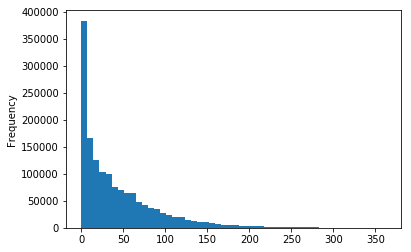

In [41]:
# Looking the rfm frequency distribution
%matplotlib inline
test['frequency'].plot(kind='hist', bins=50)

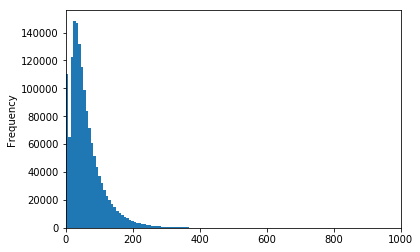

In [42]:
# Looking the rfm frequency distribution
import matplotlib.pyplot as plt
plt.xlim([0,1000])
test['monetary_value'].plot(kind='hist', bins=1000)

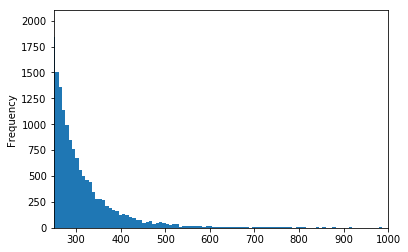

In [43]:
# More detail about monetary value
import matplotlib.pyplot as plt
plt.xlim([250,1000])
plt.ylim([0,2100])
test['monetary_value'].plot(kind='hist', bins=1000)

In [44]:
# Not delete the outlier and have a try
test = test.loc[(test['frequency'] > 0) & (test['frequency'] < 250)& (test['monetary_value'] <= 500)]

In [45]:
test = test.loc[(test['frequency'] > 0) & (test['monetary_value'] > 0)]

print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        test['frequency'],
        test['monetary_value']
    ).mean(),
    test[test['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 65.13645509748969, Average profit: 64.13624084849846


In [46]:
test_predict = ggf.conditional_expected_average_profit(
        test['frequency'],
        test['monetary_value'])
test_actual = test['monetary_value']
test_predict_actual = pd.concat([test_actual,test_predict],axis =1)
# Rename the column name
test_predict_actual.columns = ['Actual', 'Predict']
test_predict_actual['difference'] = (test_predict_actual['Predict']-test_predict_actual['Actual'])/test_predict_actual['Actual']
test_predict_actual.head()

,Actual,Predict,difference
customer_id,,,
2100000000,134.787838,135.159068,0.002754
2100000001,31.061558,31.141369,0.002569
2100000002,29.300000,30.830678,0.052242
2100000003,59.866783,59.924445,0.000963
2100000004,19.970553,19.997348,0.001342


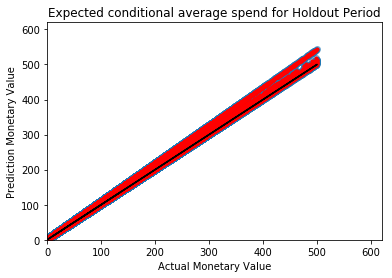

In [47]:
#All cusotmer 
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlim([0,620])
plt.ylim([0,620])
x = test_predict_actual['Actual'] 
y = test_predict_actual['Predict']

plt.plot(x,y,'r.') # x vs y
plt.plot(x,x,'k-') # identity line

plt.ylabel('Prediction Monetary Value')
plt.xlabel('Actual Monetary Value')
plt.title('Expected conditional average spend for Holdout Period')

plt.scatter(x, y, alpha=0.5)
plt.show()

In [48]:
prediction_test = test_predict_actual['Predict'].sum()
actual_test = test_predict_actual['Actual'].sum()
print("Total Amount Prediction:", prediction_test)
print("Total Amount holdout:", actual_test)
print("Difference:", prediction_test - actual_test)
print("Prediction Error :",(prediction_test-actual_test)/actual_test)

Total Amount Prediction: 91667184.6232482
Total Amount holdout: 90259573.10850038
Difference: 1407611.5147478282
Prediction Error : 0.01559514925974388


# 4. Predicting the customer total monetary value in next 1 year

### 4.1 Model

In [121]:
# Reading the dataset
training = pd.read_csv("training_day.csv",index_col='customer_id')
test = pd.read_csv("test_day.csv",index_col='customer_id')


# refit the BG model to the summary_with_money_value dataset
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.05)
training_model1 = training.loc[(training['frequency'] > 0) & (training['frequency'] < 250)]
bgf.fit(training_model1['frequency'], training_model1['recency'], training_model1['T'])

training_model2 = training.loc[(training['frequency'] > 0) & (training['frequency'] < 250)& (training['monetary_value'] <= 400)]
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0.05)
ggf.fit(training_model2['frequency'],
        training_model2['monetary_value'])

training = training[(training['frequency'] > 0) & (training['monetary_value'] > 0)]
customer_lifetime_value = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    training['frequency'],
    training['recency'],
    training['T'],
    training['monetary_value'],
    time=12, # months
    discount_rate=0, # Yearly discount rate ~6.0%  p.a  = 0.5% per month  
    freq = 'D'
)

### 4.2 Evaluation

In [122]:
data_20181001_20190930 = data[(data['date'] >=20181001) & (data['date'] <=20190930)]

Monetary_Value_Predict_Actual = pd.concat([customer_lifetime_value, data_20181001_20190930.groupby(['customer_id']).sum()['amount']], axis = 1)
Monetary_Value_Predict_Actual.columns = ['Predict', 'Actual']
Monetary_Value_Predict_Actual = Monetary_Value_Predict_Actual.dropna()
prediction = Monetary_Value_Predict_Actual['Predict'].sum()
actual = Monetary_Value_Predict_Actual['Actual'].sum()
print("Total Amount Prediction:", prediction)
print("Total Amount holdout:", actual)
print("Difference:", prediction - actual)
print("Prediction Error :",(prediction-actual)/actual)

Total Amount Prediction: 4249096698.3389893
Total Amount holdout: 4164719907.3399987
Difference: 84376790.99899054
Prediction Error : 0.020259895713582787


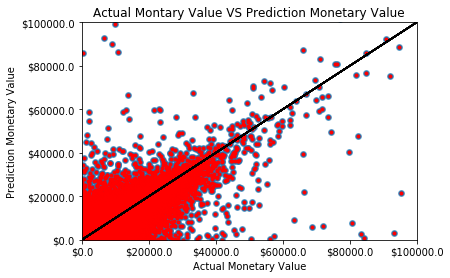

In [123]:
#All cusotmer 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


ax = Monetary_Value_Predict_Actual.plot(kind='scatter', x='Actual', y='Predict')

formatter = ticker.FormatStrFormatter('$%0.1f') #declaring the formatter with the $ sign and y_values with 1 decimalplace
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)

x = Monetary_Value_Predict_Actual['Actual'] 
y = Monetary_Value_Predict_Actual['Predict']
plt.plot(x,y,'r.') # x vs y
plt.plot(x,x,'k-') # identity line

plt.xlim([0,100000])
plt.ylim([0,100000])

plt.ylabel('Prediction Monetary Value')
plt.xlabel('Actual Monetary Value')
plt.title('Actual Montary Value VS Prediction Monetary Value')

mpl.rcParams['agg.path.chunksize'] = 100000
plt.scatter(x, y, alpha=0.5)
plt.show()

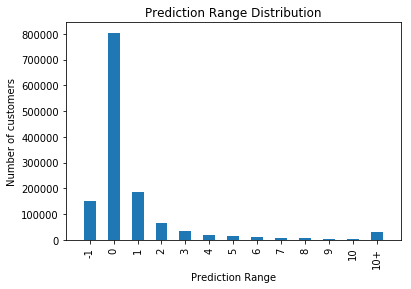

In [56]:
# Get the difference for every customer
Monetary_Value_Predict_Actual['Difference'] = round((Monetary_Value_Predict_Actual['Predict'] - Monetary_Value_Predict_Actual['Actual'])/Monetary_Value_Predict_Actual['Actual'],0)
difference = pd.DataFrame(Monetary_Value_Predict_Actual["Difference"].value_counts())
difference = difference.sort_index(ascending=True)

difference_ten = difference.loc[-1:10]
difference_ten = difference_ten.append({'Difference' : 28832 } , ignore_index=True)
difference_ten.rename(index={0: -1, 1:0, 2: 1, 3:2, 4: 3, 5:4, 6: 5, 7:6, 8: 7, 9:8, 10: 9, 11: 10,12: '10+'}, inplace= True)

ax = difference_ten.plot(kind='bar')
plt.xlim([-1,13])
plt.ylabel('Number of customers')
plt.xlabel('Prediction Range')
plt.title('Prediction Range Distribution')
ax.legend().set_visible(False)
plt.show()

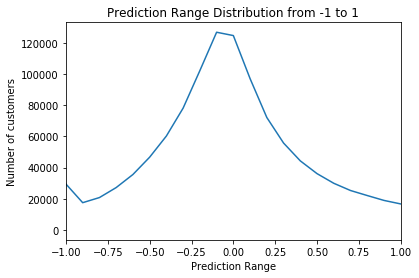

In [57]:
# Get the difference for every customer
Monetary_Value_Predict_Actual['Difference'] = round((Monetary_Value_Predict_Actual['Predict'] - Monetary_Value_Predict_Actual['Actual'])/Monetary_Value_Predict_Actual['Actual'],1)
difference = pd.DataFrame(Monetary_Value_Predict_Actual["Difference"].value_counts())
difference = difference.sort_index(ascending=True)
difference_range = difference[(difference['Difference']>=-1) & (difference['Difference']<=1)]

ax = difference.plot(kind='line')
plt.xlim([-1,1])
plt.ylabel('Number of customers')
plt.xlabel('Prediction Range')
plt.title('Prediction Range Distribution from -1 to 1')
ax.legend().set_visible(False)
plt.show()

### 4.3 Visullization for next 5 years

In [7]:
# Reading the dataset
training = pd.read_csv("training_day.csv",index_col='customer_id')
test = pd.read_csv("test_day.csv",index_col='customer_id')


# refit the BG model to the summary_with_money_value dataset
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.05)
training_model1 = training.loc[(training['frequency'] > 0) & (training['frequency'] < 250)]
bgf.fit(training_model1['frequency'], training_model1['recency'], training_model1['T'])

training_model2 = training.loc[(training['frequency'] > 0) & (training['frequency'] < 250)& (training['monetary_value'] <= 400)]
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0.05)
ggf.fit(training_model2['frequency'],
        training_model2['monetary_value'])

training = training[(training['frequency'] > 0) & (training['monetary_value'] > 0)]
customer_lifetime_value_2019 = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    training['frequency'],
    training['recency'],
    training['T'],
    training['monetary_value'],
    time=12, # months
    discount_rate=0.005, # Yearly discount rate ~6.0%  p.a  = 0.5% per month  
    freq = 'D'
)

In [8]:
# Reading the dataset
training = pd.read_csv("training_day.csv",index_col='customer_id')
test = pd.read_csv("test_day.csv",index_col='customer_id')


# refit the BG model to the summary_with_money_value dataset
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.05)
training_model1 = training.loc[(training['frequency'] > 0) & (training['frequency'] < 250)]
bgf.fit(training_model1['frequency'], training_model1['recency'], training_model1['T'])

training_model2 = training.loc[(training['frequency'] > 0) & (training['frequency'] < 250)& (training['monetary_value'] <= 400)]
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0.05)
ggf.fit(training_model2['frequency'],
        training_model2['monetary_value'])

training = training[(training['frequency'] > 0) & (training['monetary_value'] > 0)]
customer_lifetime_value_2024 = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    training['frequency'],
    training['recency'],
    training['T'],
    training['monetary_value'],
    time=72, # months
    discount_rate=0.005, # Yearly discount rate ~6.0%  p.a  = 0.5% per month  
    freq = 'D'
)

In [44]:
# total clv 2024 minus total clv 2019
customer_lifetime_value_5years = customer_lifetime_value_2024-customer_lifetime_value_2019
customer_lifetime_value_5years.head()

customer_id
2100000000    35358.055334
2100000001    14072.758098
2100000002      353.179552
2100000003    35338.548225
2100000004    15092.754860
Name: clv, dtype: float64

Text(0.5,1,'Customers total $dollar Spend for next 5 years distrbution (6% Discount Rate)')

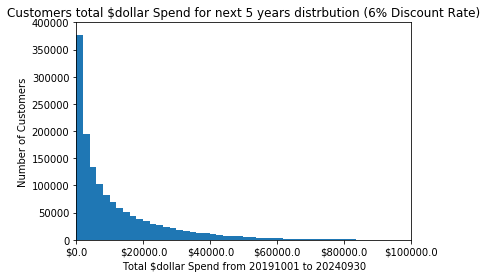

In [83]:
# Plotting the distribution
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.xlim([0,100000])
plt.ylim([0,400000])

ax = customer_lifetime_value_5years.plot(kind='hist', bins=1000)

formatter = ticker.FormatStrFormatter('$%0.1f') #declaring the formatter with the $ sign and y_values with 1 decimalplace
ax.xaxis.set_major_formatter(formatter)

plt.ylabel('Number of Customers')
plt.xlabel('Total $dollar Spend from 20191001 to 20240930')
plt.title('Customers total $dollar Spend for next 5 years distrbution (6% Discount Rate)')

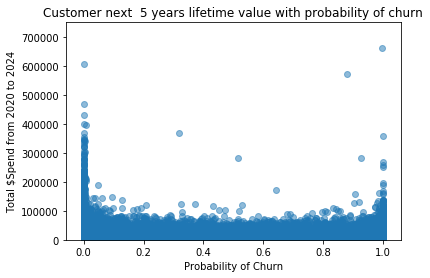

In [50]:
# Merge the probability of churn and CLV next 5 years
clv_5years = pd.concat([customer_lifetime_value_5years,test_probability_alive['Churn']], axis = 1).dropna()

x = clv_5years['Churn']
y = clv_5years['clv']
ax = plt.scatter(x, y, alpha=0.5)

plt.ylim([0,750000])
plt.ylabel('Total $Spend from 2020 to 2024')
plt.xlabel('Probability of Churn')
plt.title('Customer next  5 years lifetime value with probability of churn')
#ax.legend().set_visible(False)
plt.show()

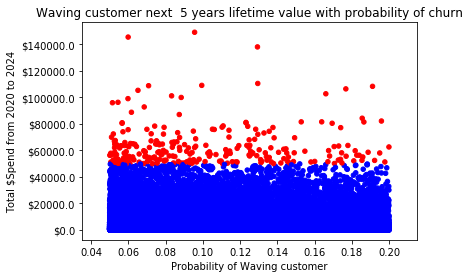

In [112]:
# For the Waving customers
clv_5years_waving = clv_5years[(clv_5years['Churn'] >0.05) & (clv_5years['Churn'] <0.2)]

colors = np.where(clv_5years_waving["clv"]>=50000,'r','b')
ax = clv_5years_waving.plot(kind='scatter', x='Churn', y='clv',c=colors)

formatter = ticker.FormatStrFormatter('$%0.1f') #declaring the formatter with the $ sign and y_values with 1 decimalplace
ax.yaxis.set_major_formatter(formatter)

#plt.ylim([0,750000])
plt.ylabel('Total $Spend from 2020 to 2024')
plt.xlabel('Probability of Waving customer')
plt.title('Waving customer next  5 years lifetime value with probability of churn')
#ax.legend().set_visible(False)
plt.show()

In [113]:
clv_5years_waving[clv_5years_waving["clv"]>=50000].shape

(254, 2)

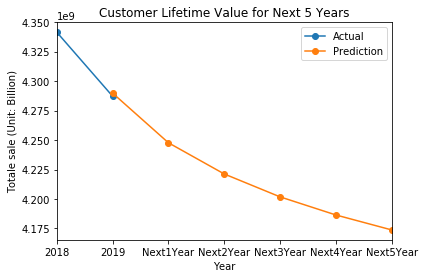

In [3]:
#No Discount 
a= {'Actual':[4341439234,4287138878, None, None, None, None,None],'Prediction':[None,4289766150,4247675722,4221221544,4201801372,4186447729,4173752048] }
a_dataframe = pd.DataFrame(a)
a_dataframe
a_dataframe.rename(index={0: 2018, 1:2019, 2: 'Next1Year', 3:'Next2Year', 4: 'Next3Year', 5:'Next4Year', 6: 'Next5Year'}, inplace= True)

%matplotlib inline
import matplotlib.pyplot as plt

ax = a_dataframe.plot(kind='line',marker='o')

plt.ylabel('Totale sale (Unit: Billion)')
plt.xlabel('Year')
plt.title('Customer Lifetime Value for Next 5 Years')
#ax.legend().set_visible(False)
plt.show()

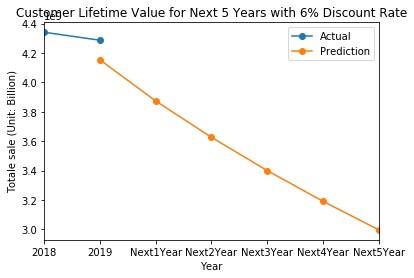

In [4]:
# With Discount = 0.005%
a= {'Actual':[4341439234,4287138878, None, None, None, None,None],'Prediction':[None,4153813107,3873999987,3626176354,3399781349,3190559058,2996083484] }
a_dataframe = pd.DataFrame(a)
a_dataframe
a_dataframe.rename(index={0: 2018, 1:2019, 2: 'Next1Year', 3:'Next2Year', 4: 'Next3Year', 5:'Next4Year', 6: 'Next5Year'}, inplace= True)

%matplotlib inline
import matplotlib.pyplot as plt

ax = a_dataframe.plot(kind='line',marker='o')

plt.ylabel('Totale sale (Unit: Billion)')
plt.xlabel('Year')
plt.title('Customer Lifetime Value for Next 5 Years with 6% Discount Rate')
#ax.legend().set_visible(False)
plt.show()